# SNAP Gap in Los Angeles County: Spatial Patterns and Predictors
#### Meaghan Woody

### Part 1: Mapping SNAP Rate and SNAP Gap

The observed SNAP participation rate was calculated as percentage of all households receiving SNAP divided by the denominator specified by ACS for that variable (All households in the tract (SNAP participants + nonparticipants).

The SNAP Gap, also defined as SNAP-Eligible But Not Enrolled (EBNE), was calculated as households below the FPL (variable specified by ACS) who are not enrolled in the SNAP program divided by households up to 150% FPL. 

This is a conservative proxy for the percentage of eligible but not enrolled (EBNE) households by census tract, because, in California, households can make less than or equal to 130% of the federal poverty level and still qualify for the SNAP program. However, under California's modified categorical eligibility standard, eligibility can go up to 200% of FPL. The 150% cut-off was chosen as a estimate. 

In [63]:
# Load in the files for mapping

import geopandas as gpd

# Tract-level
snap_tracts = gpd.read_file("/Users/markwoody/Desktop/UP 213/UP213Final/final/data/snap_tracts_exp.gpkg")

# ZIP-code level
snap_zcta = gpd.read_file("/Users/markwoody/Desktop/UP 213/UP213Final/final/data/snap_zcta_exp.gpkg")

In [65]:
# Check for missing values
snap_tracts['snap_ebne'].isna().sum() 
snap_tracts['snap_rate'].isna().sum()

# 29 tracts have missing values. This small proportiion should not mess up any calculation. 

30

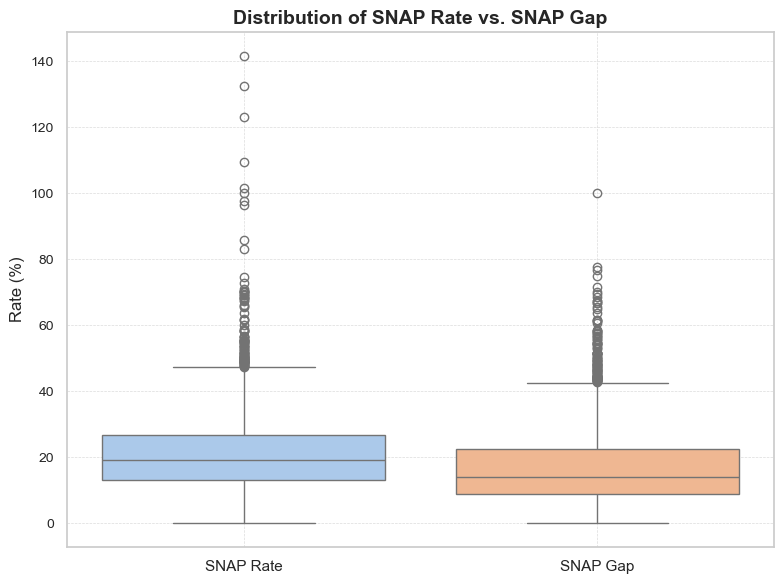

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Create the boxplot for SNAP Rates and SNAP Gap
plt.figure(figsize=(8, 6))
sns.boxplot(data=snap_tracts[['snap_rate', 'snap_ebne']], palette="pastel")
plt.title('Distribution of SNAP Rate vs. SNAP Gap', fontsize=14, weight='bold')
plt.ylabel('Rate (%)', fontsize=12)
plt.xticks([0, 1], ['SNAP Rate', 'SNAP Gap'], fontsize=11)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [69]:
# Mean and standard deviatiion
table = snap_tracts[['snap_rate', 'snap_ebne']].agg(['mean', 'std'])
print(table)

      snap_rate  snap_ebne
mean  21.289411  17.320289
std   13.223573  11.906589


SNAP Rate mean is 21.29% with a standard deviation of 17.32%. This is much lower than expected due to methodological limitations. First, the denominator includes households up to 150% FPL, many of which could be ineligible for SNAP under standard 130% FPL rules, unless they have individual cases. Second, ACS survey data undercounts actual SNAP participation due to benefit underreporting and mismatches between annual (ACS) and monthly (SNAP) eligibility windows. 

The SNAP Gap mean is 17.32% with a standard deviation of 11.90%. The SNAP Gap rates in Los Angeles County have not been documented recently. 

The following maps will show the local areas of SNAP utilization and where outreach is needed. 

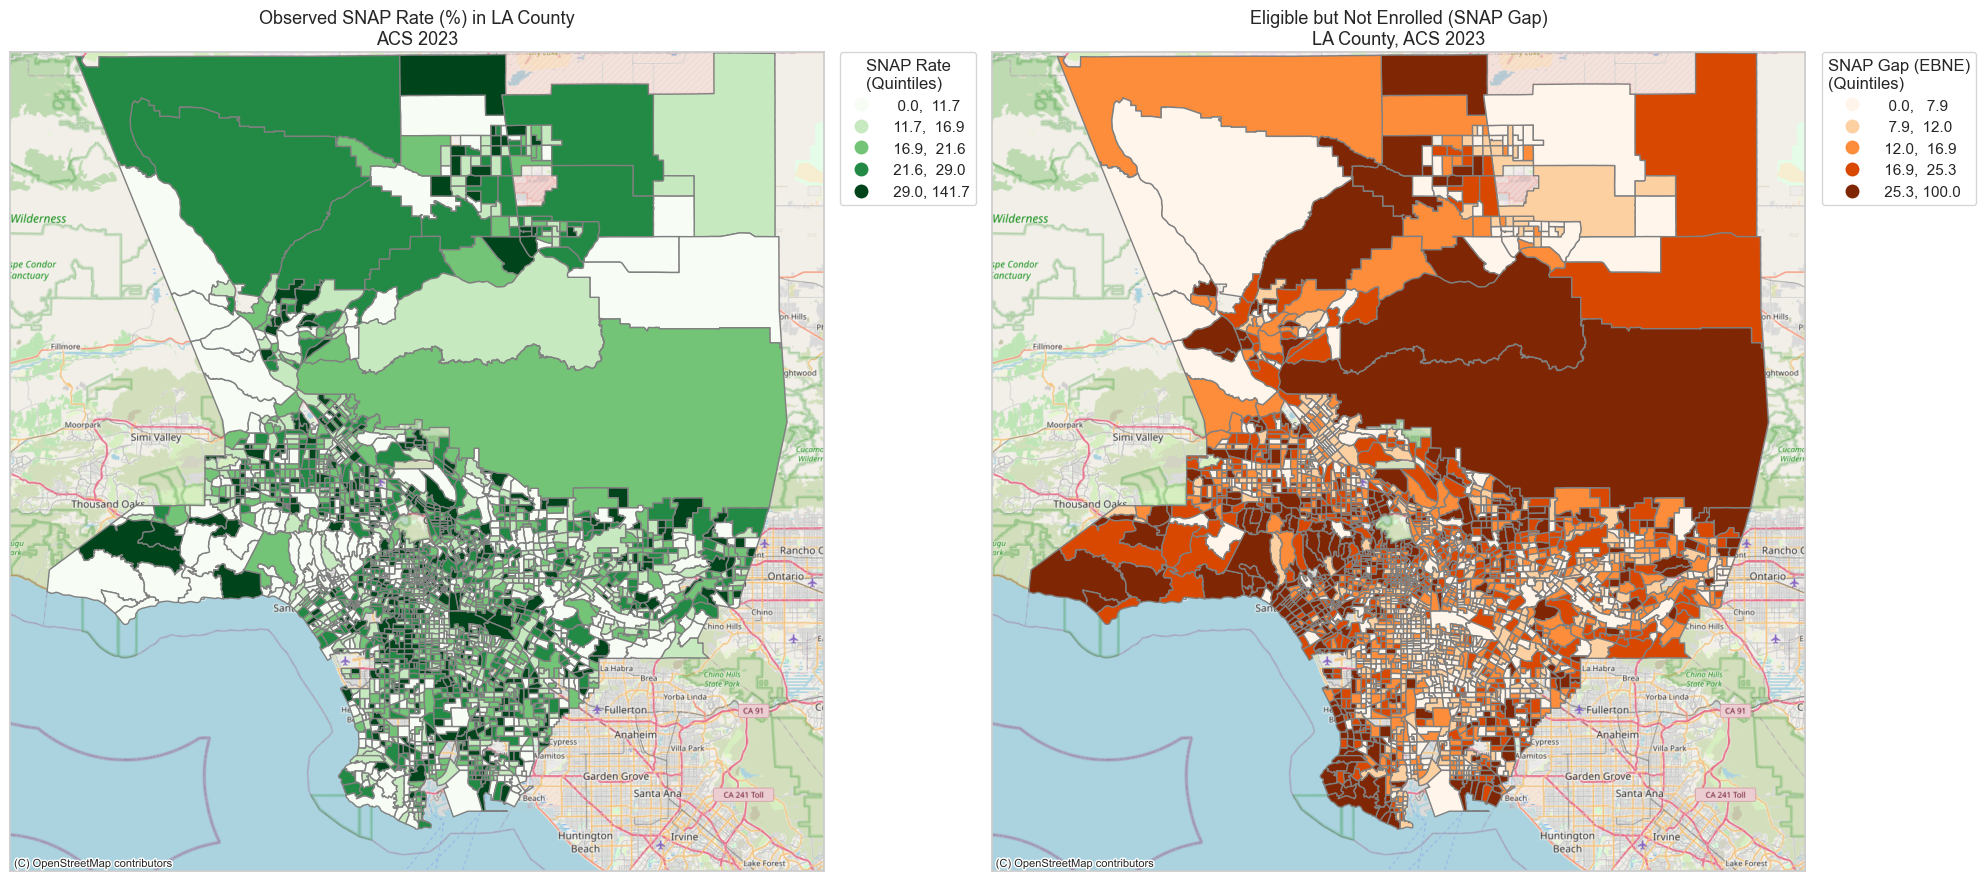

In [78]:
## Tract level Maps

import matplotlib.pyplot as plt
import contextily as ctx

# Create side-by-side figure
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))

# Reproject to Web Mercator
snap_tracts_web = snap_tracts.to_crs('EPSG:3857')

# SNAP Rate Map
snap_tracts_web.plot(
    column='snap_rate',
    scheme='quantiles',
    k=5,
    cmap='Greens',
    legend=True,
    ax=ax1,
    alpha=1,
    edgecolor='gray',
    legend_kwds={
        'fmt': "{:.1f}",
        'title': "SNAP Rate\n(Quintiles)",
        'loc': 'upper left',
        'bbox_to_anchor': (1.02, 1),
        'borderaxespad': 0
    }
)
ax1.set_title("Observed SNAP Rate (%) in LA County\nACS 2023", fontsize=13)
ax1.set_ylim([3.98e6, 4.14e6])
ax1.set_xticks([])
ax1.set_yticks([])
ctx.add_basemap(ax1, zoom=10, source=ctx.providers.OpenStreetMap.Mapnik)

# SNAP Gap Map (EBNE)
snap_tracts_web.plot(
    column='snap_ebne',
    scheme='quantiles',
    k=5,
    cmap='Oranges',
    legend=True,
    ax=ax2,
    alpha=1,
    edgecolor='gray',
    legend_kwds={
        'fmt': "{:.1f}",
        'title': "SNAP Gap (EBNE)\n(Quintiles)",
        'loc': 'upper left',
        'bbox_to_anchor': (1.02, 1),
        'borderaxespad': 0
    }
)
ax2.set_title("Eligible but Not Enrolled (SNAP Gap)\nLA County, ACS 2023", fontsize=13)
ax2.set_ylim([3.98e6, 4.14e6])
ax2.set_xticks([])
ax2.set_yticks([])
ctx.add_basemap(ax2, zoom=10, source=ctx.providers.OpenStreetMap.Mapnik)

plt.tight_layout()
plt.show()

As suspected, tracts might be too small of a unit to assess what is going on in terms of SNAP gap and SNAP rate. One interesting thing to note is how West LA is showing higher SNAP gap, even though it is typically a higher income area. Central and South Central LA appears to have higher SNAP rate participation and lower SNAP gap. South LA has a higher SNAP Gap. 

### Part 2. Spatial Clusters

Since the tracts are so small, it might be meaningful to see if there are any spatial clusters in the SNAP rate or SNAP gap showing aggregagted areas of need of participation. 

In [102]:
snap_tracts.head(2)

GEOID B05002_021E B05002_013E B01001_002E B01001_026E B01001_020E  \
0  06037101110         347        1608        2035        2117         101   
1  06037101122         347        2122        2130        2068          49   

  B01001_021E B01001_022E B01001_023E B01001_024E  ... %_undergrad  %_renters  \
0         120          55          50          63  ...   32.312253  48.780488   
1          66         149          54          32  ...   31.619537  22.103767   

  %_rent_burd  %_no_int %_no_vehic  snap_ebne  snap_rate median_income  \
0    52.50000  8.023107   3.786906  23.300971  45.792880       84091.0   
1    69.77492  1.350391   0.000000   6.601467  39.119804       99583.0   

  avg_hh_size                                           geometry  
0        2.60  MULTIPOLYGON (((-118.30229 34.2587, -118.30091...  
1        2.98  MULTIPOLYGON (((-118.30334 34.27371, -118.3033...  

[2 rows x 66 columns]

In [128]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Look at two features of SNAP 
features = ['snap_ebne', 'snap_rate']
df_cluster = snap_tracts[features].dropna()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# Use KMeans function for clustering
kmeans = KMeans(n_clusters=5, random_state=1)
cluster_labels = kmeans.fit_predict(X_scaled)

# Assign cluster labels to original GeoDataFrame
snap_tracts.loc[df_cluster.index, 'cluster_id'] = cluster_labels

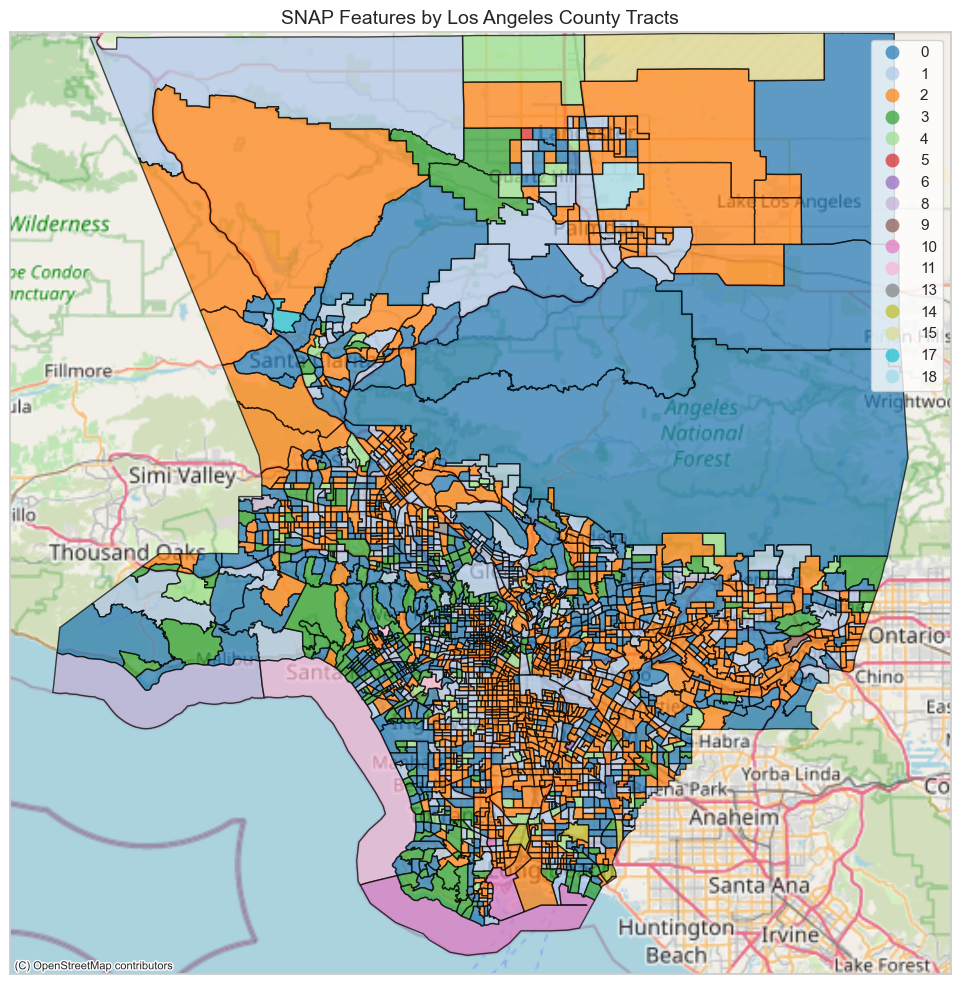

In [134]:
import matplotlib.pyplot as plt
import contextily as ctx

fig, ax = plt.subplots(figsize=(10, 10))
snap_tracts.to_crs('EPSG:3857').plot(
    column='cluster_id',
    categorical=True,
    legend=True,
    cmap='tab20',
    ax=ax,
    alpha=0.7,
    edgecolor='black',
)
ax.set_ylim([3.98e6, 4.14e6])
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("SNAP Features by Los Angeles County Tracts", fontsize=14)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

In [138]:
# Summary table
snap_tracts.groupby('cluster_id')[['snap_rate', 'snap_ebne']].mean().round(1)

snap_rate  snap_ebne
cluster_id                      
0                13.5       23.6
1                32.5       14.3
2                16.6        9.3
3                14.8       44.8
4                60.3       21.5
5                 NaN        NaN
6                 NaN        NaN
8                 NaN        NaN
9                 NaN        NaN
10                NaN        NaN
11                NaN        NaN
13                NaN        NaN
14                NaN        NaN
15                NaN        NaN
17                NaN        NaN
18                NaN        NaN

Only clusters 0 to 4 had enough data to present on the map. Cluster 0 showed low SNAP usage but moderate SNAP gap, spread out all over the county but especially in the Antellope Valley. Cluster 1 showed higher SNAP usage, and low gap, likely better-served areas. Cluster 2 showed moderate usage, very low gap, centered in South LA. Cluster 3 had the highest SNAP Gap, which were only a few sites across the county in the far north, far west, and far south. Cluster 4 had the highest SNAP usage rate, which are only a few random areas across the county.

### Part 3. Aggregate to Service Planning Areas

SNAP outreach may not be meaningful at the tract-level and produciing results at the SPA-level might be better for a quick snapshot to see what is happening. Service planning areas (SPAs) are distinct geographic regions used by the Los Angeles Department of Public Health to develop and provide more relevant and targeted outreach to the specific health needs of the residents in these different areas.

Downloaded Los Angeles County Service Planning Areas (SPAs) 2022 from https://egis-lacounty.hub.arcgis.com/datasets/lacounty::service-planning-areas-2022-view/about

First, repeat the same mapping procedures for SNAP rate and SNAP gap at the SPA-level.

In [144]:
# Load in the SPA boundaries

spas = gpd.read_file('/Users/markwoody/Desktop/UP 213/UP213Final/final/data/Service_Planning_Areas_2022_view_8558881845522833049.zip')
spas = spas.to_crs(epsg=4326)
spas.head(5)

SPA         SPA_NAME ABBV  LABEL  SPA_NUM  \
0   1  Antelope Valley  ATV  SPA 1        1   
1   2     San Fernando  SFV  SPA 2        2   
2   3      San Gabriel  SGV  SPA 3        3   
3   4            Metro  MET  SPA 4        4   
4   5             West    W  SPA 5        5   

                                            geometry  
0  POLYGON ((-117.65523 34.39722, -117.65524 34.3...  
1  POLYGON ((-118.7659 34.75362, -118.77967 34.75...  
2  POLYGON ((-117.97228 34.43878, -117.9723 34.43...  
3  POLYGON ((-118.30434 34.15884, -118.30283 34.1...  
4  POLYGON ((-118.94469 34.045, -118.94463 34.045...

In [146]:
# Spatial join 
tracts_spa = gpd.sjoin(snap_tracts, spas, how='left', predicate='within')
tracts_spa.head(5)

GEOID B05002_021E B05002_013E B01001_002E B01001_026E B01001_020E  \
0  06037101110         347        1608        2035        2117         101   
1  06037101122         347        2122        2130        2068          49   
2  06037101220         600        1559        1585        1849          13   
3  06037101221         761        2100        2046        1885          65   
4  06037101222         456        1414        1239        1333          23   

  B01001_021E B01001_022E B01001_023E B01001_024E  ...  \
0         120          55          50          63  ...   
1          66         149          54          32  ...   
2          50          74          27          34  ...   
3          57         100          19           0  ...   
4          49          38          16           0  ...   

                      centroid         lon        lat cluster_id index_right  \
0  POINT (-118.29299 34.25947) -118.292987  34.259474          4         1.0   
1  POINT (-118.29015 34.26772) -118.290147  34.267722          1         1.0   
2  POINT (-118.28163 34.25161) -118.281633  34.251608          4         1.0   
3  POINT (-118.29258 34.25433) -118.292577  34.254329          1         1.0   
4  POINT (-118.28853 34.25135) -118.288526  34.251352          1         1.0   

  SPA      SPA_NAME ABBV  LABEL SPA_NUM  
0   2  San Fernando  SFV  SPA 2     2.0  
1   2  San Fernando  SFV  SPA 2     2.0  
2   2  San Fernando  SFV  SPA 2     2.0  
3   2  San Fernando  SFV  SPA 2     2.0  
4   2  San Fernando  SFV  SPA 2     2.0  

[5 rows x 76 columns]

In [150]:
# Aggregate up to SPAs
cols = ['snap_rate', 'snap_ebne']
spa_aggregated = tracts_spa.groupby('SPA')[cols].mean().reset_index()
spa_aggregated.head(5)

SPA  snap_rate  snap_ebne
0   1  22.955604  11.752398
1   2  22.802202  17.534819
2   3  18.496464  16.034030
3   4  23.352959  20.023803
4   5  18.386770  28.132028

In [158]:
# Merge with SPA geometries
snap_spa = spas.merge(spa_aggregated, on='SPA')
snap_spa.head(8)

SPA         SPA_NAME ABBV  LABEL  SPA_NUM  \
0   1  Antelope Valley  ATV  SPA 1        1   
1   2     San Fernando  SFV  SPA 2        2   
2   3      San Gabriel  SGV  SPA 3        3   
3   4            Metro  MET  SPA 4        4   
4   5             West    W  SPA 5        5   
5   6            South    S  SPA 6        6   
6   7             East    E  SPA 7        7   

                                            geometry  snap_rate  snap_ebne  
0  POLYGON ((-117.65523 34.39722, -117.65524 34.3...  22.955604  11.752398  
1  POLYGON ((-118.7659 34.75362, -118.77967 34.75...  22.802202  17.534819  
2  POLYGON ((-117.97228 34.43878, -117.9723 34.43...  18.496464  16.034030  
3  POLYGON ((-118.30434 34.15884, -118.30283 34.1...  23.352959  20.023803  
4  POLYGON ((-118.94469 34.045, -118.94463 34.045...  18.386770  28.132028  
5  POLYGON ((-118.34542 34.03996, -118.34471 34.0...  22.977673  10.695379  
6  MULTIPOLYGON (((-118.1741 33.81892, -118.17414...  21.156264  12.797156

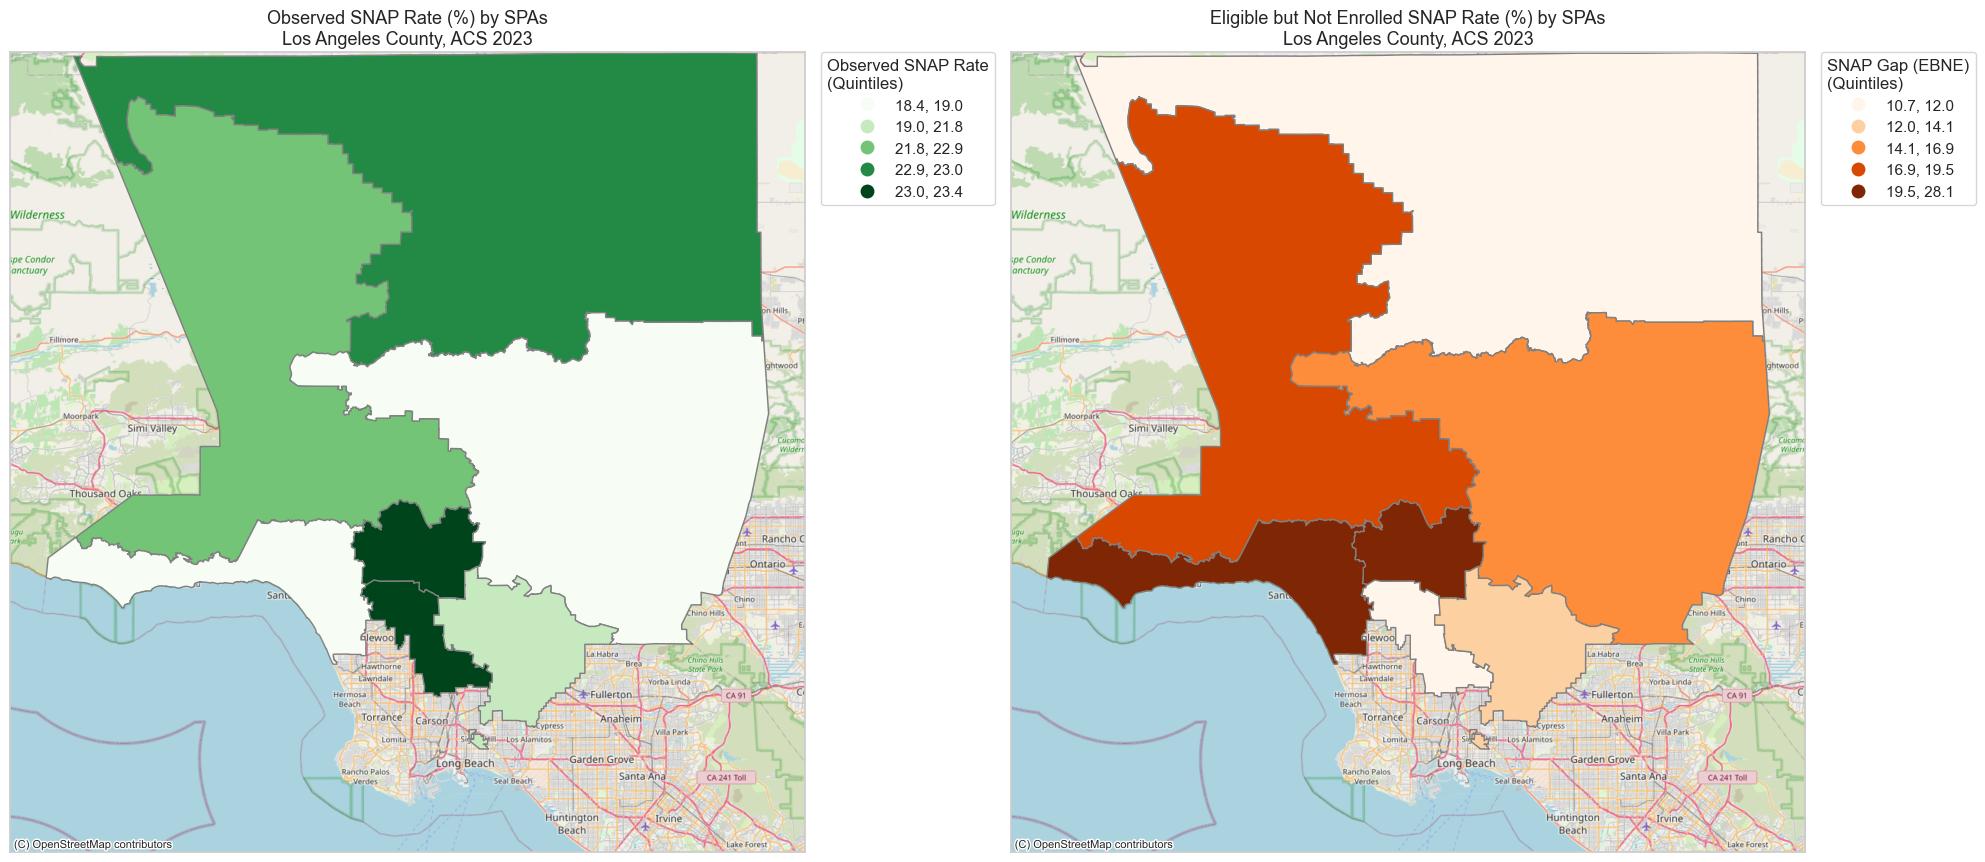

In [156]:
import matplotlib.pyplot as plt
import contextily as ctx

# Reproject
spa_web = snap_spa.to_crs('EPSG:3857')

# Set up side-by-side figure
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))

# Plot Observed SNAP Rate (Green)
spa_web.plot(
    column='snap_rate',
    scheme='quantiles',
    k=5,
    cmap='Greens',
    legend=True,
    ax=ax1,
    edgecolor='gray',
    alpha=1,
    legend_kwds={
        'fmt': "{:.1f}",
        'title': "Observed SNAP Rate\n(Quintiles)",
        'loc': 'upper left',
        'bbox_to_anchor': (1.02, 1),
        'borderaxespad': 0
    }
)
ax1.set_title('Observed SNAP Rate (%) by SPAs\nLos Angeles County, ACS 2023', fontsize=13)
ax1.set_ylim([3.98e6, 4.14e6])
ax1.set_xticks([])
ax1.set_yticks([])
ctx.add_basemap(ax1, zoom=10, source=ctx.providers.OpenStreetMap.Mapnik)

# Plot SNAP Gap (EBNE) in Orange
spa_web.plot(
    column='snap_ebne',
    scheme='quantiles',
    k=5,
    cmap='Oranges',
    legend=True,
    ax=ax2,
    edgecolor='gray',
    alpha=1,
    legend_kwds={
        'fmt': "{:.1f}",
        'title': "SNAP Gap (EBNE)\n(Quintiles)",
        'loc': 'upper left',
        'bbox_to_anchor': (1.02, 1),
        'borderaxespad': 0
    }
)
ax2.set_title('Eligible but Not Enrolled SNAP Rate (%) by SPAs\nLos Angeles County, ACS 2023', fontsize=13)
ax2.set_ylim([3.98e6, 4.14e6])
ax2.set_xticks([])
ax2.set_yticks([])
ctx.add_basemap(ax2, zoom=10, source=ctx.providers.OpenStreetMap.Mapnik)

plt.tight_layout()
plt.show()

### Summary of SPA Attributes

In [181]:
# Create summary table
summary_table = snap_spa[['SPA_NAME', 'snap_rate', 'snap_ebne']].groupby('SPA_NAME').mean()

summary_table = summary_table.rename(columns={
    'snap_rate': 'Avg SNAP Rate (%)',
    'snap_ebne': 'Avg EBNE Rate (%)'
})

# Sort by SNAP rate (highest to lowest)
summary_table = summary_table.sort_values('Avg SNAP Rate (%)', ascending=False)

# Format with 1 decimal place
summary_table = summary_table.round(1)

from IPython.display import display, HTML
display(HTML(summary_table.to_html()))

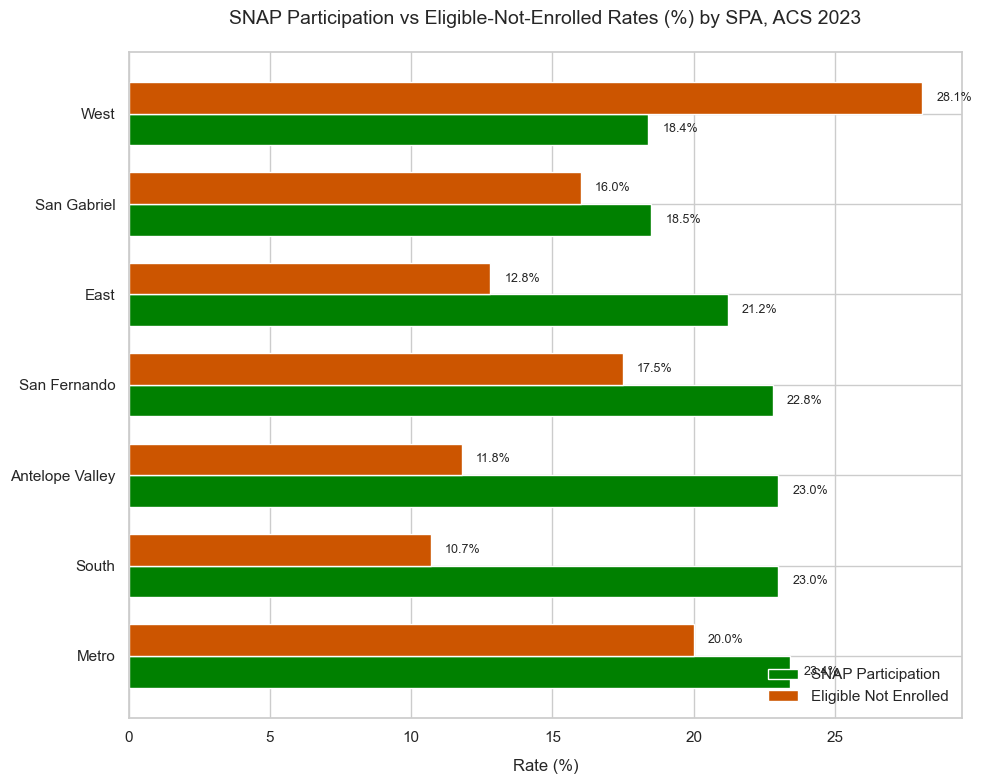

In [189]:
# Create a bar chart 
spa_names = summary_table.index 
fig, ax = plt.subplots(figsize=(10, 8))  # unpack fig and ax correctly
width = 0.35  # Width of each bar
y = np.arange(len(spa_names)) 

bars1 = ax.barh(y - width/2, summary_table['Avg SNAP Rate (%)'], width, 
                label='SNAP Participation', color='green')
bars2 = ax.barh(y + width/2, summary_table['Avg EBNE Rate (%)'], width, 
                label='Eligible Not Enrolled', color='#cc5500')  # darker orange

ax.set_title('SNAP Participation vs Eligible-Not-Enrolled Rates (%) by SPA, ACS 2023', pad=20, fontsize=14)
ax.set_xlabel('Rate (%)', labelpad=10)
ax.set_yticks(y)
ax.set_yticklabels(spa_names)
ax.legend(loc='lower right', frameon=False)

# Add value labels
for bar in bars1 + bars2:
    bar_width = bar.get_width()
    ax.text(bar_width + 0.5,  
            bar.get_y() + bar.get_height()/2,
            f'{bar_width:.1f}%',
            va='center',
            fontsize=9)

plt.tight_layout()
plt.show()

### Part 4. Statistics on Food Insecurity 

In order to get the full picture of where outreach is needed for CalFresh, it is necessary to understand the spatial disparities of food insecurity in Los Angeles County.

SPA-level reports on food insecurity. Downloaded data from Los Angeles City Geohub: https://geohub.lacity.org/datasets/9ecfeddddb9e4630aa10c92b0daeea6c_0/explore?location=33.771520%2C-118.353165%2C8.16

Population in Households with Food Insecurity by each city. Data provided by Los Angeles County Department of Public Health (DPH) for the Community Health Profiles (CHP) Data Initiative: https://geohub.lacity.org/datasets/9b5c7a6b308f4091813d0e6e64e852c7_0/explore?location=33.871267%2C-118.342846%2C8.43

"Data for cities, communities, and City of Los Angeles Council Districts were generated using a small area estimation method which combined the survey data with population benchmark data (2022 population estimates for Los Angeles County) and neighborhood characteristics data (e.g., U.S. Census Bureau, 2017-2021 American Community Survey 5-Year Estimates). Households experiencing food insecurity are defined as those with low food security or very low food security in the last 12 months. Food insecurity is assessed by a scaled variable created from a series of five questions."

In [202]:
# Load in SPA-level FI data

spa_fi = gpd.read_file('/Users/markwoody/Desktop/UP 213/UP213Final/final/data/SPA_and_food_insecurity.zip')
print(spa_fi.columns)
spa_fi.head(2)

# Remove the % format on Food_Insec column and convert to float
spa_fi['FI'] = spa_fi['Food_Insec'].str.replace('%', '').astype(float)
print(spa_fi['FI'])

Index(['OBJECTID_1', 'OBJECTID', 'SPA_NAME', 'LABEL', 'ABBV', 'SPA_2012',
       'Join_Count', 'SPA_Number', 'Median_Inc', 'Index_', 'SPA', 'Food_Secur',
       'Food_Insec', 'geometry'],
      dtype='object')
0    16.0
1    17.0
2     4.0
3    22.0
4     9.0
5    18.0
6     9.0
7     5.0
Name: FI, dtype: float64


In [208]:
# Load in the City-level FI data

city_fi = gpd.read_file('/Users/markwoody/Desktop/UP 213/UP213Final/final/data/Population_with_Food_Insecurity_3358006855397152269.zip')
print(city_fi.columns)
city_fi.head(2)

Index(['Geo_ID', 'Geo_Type', 'Geo_Name', 'POP_FI', 'POP_FI_LCL', 'POP_FI_UCL',
       'POP_FI_RSE', 'POP_FI_EST', 'geometry'],
      dtype='object')


Geo_ID           Geo_Type              Geo_Name  POP_FI  \
0  csa_city_agoura_hills  Incorporated City  City of Agoura Hills     0.0   
1      csa_city_alhambra  Incorporated City      City of Alhambra    21.1   

   POP_FI_LCL  POP_FI_UCL  POP_FI_RSE           POP_FI_EST  \
0         0.0         0.0         0.0                 None   
1        19.0        23.2         5.1  small area estimate   

                                            geometry  
0  POLYGON ((6341261 1884292.5, 6341258 1884280, ...  
1  POLYGON ((6525011 1860749.875, 6525931.5 18612...

#### Explore SPA-level food insecurity rates

Text(0.5, 1.0, 'Food Insecurity by SPAs in Los Angeles County, 2021: Source: LA City Geohub')

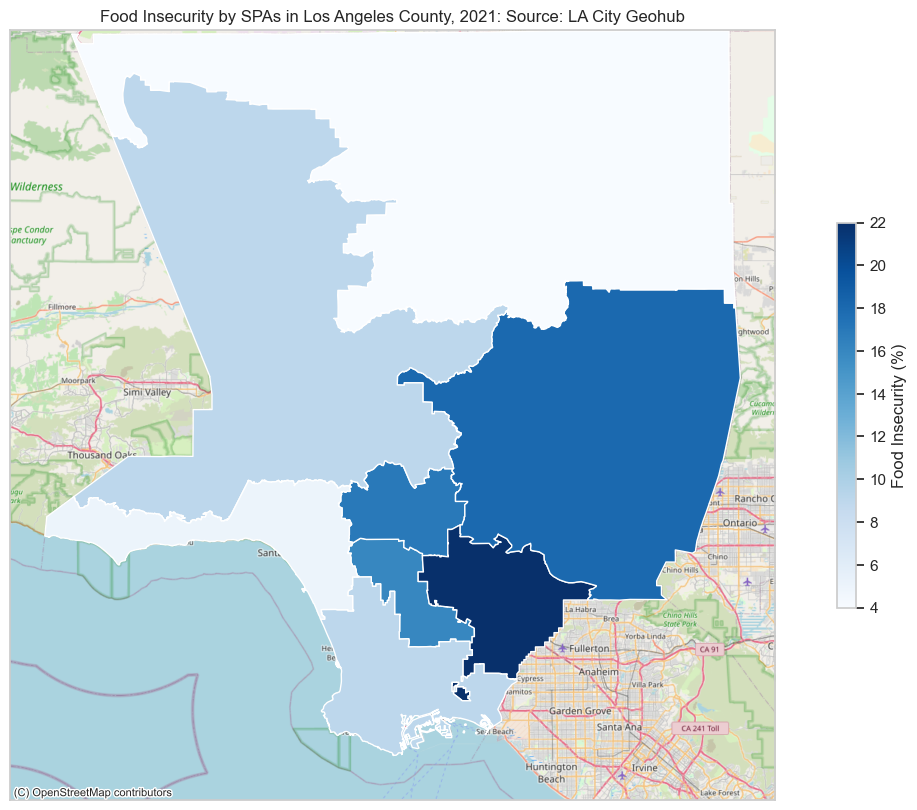

In [212]:
fig4, ax = plt.subplots(figsize=(16,10))

spa_fi.to_crs('EPSG:3857').plot(
    column='FI',
        ax=ax,
        markersize=20,  # Consistent size
        cmap='Blues',
        legend=True,
        legend_kwds={'label': "Food Insecurity (%)",
        'shrink': 0.5,  # make the color bar shorter
        'aspect': 20} # controls width — higher = skinnier                         
                     )

# drop Catalina
ax.set_ylim([3.98e6, 4.14e6])

# add a basemap
ctx.add_basemap(ax=ax, zoom=10, source=ctx.providers.OpenStreetMap.Mapnik)

# drop the tick labels
ax.set_xticks([])
ax.set_yticks([])

# add a title
ax.set_title('Food Insecurity by SPAs in Los Angeles County, 2021: Source: LA City Geohub')

In [214]:
# Create summary table for FI
fi_summary = spa_fi[['SPA_NAME', 'FI']].groupby('SPA_NAME').mean()

# Rename and format
fi_summary = fi_summary.rename(columns={'FI': 'Food Insecurity Rate (%)'})
fi_summary = fi_summary.round(1)

# Sort highest to lowest
fi_summary = fi_summary.sort_values('Food Insecurity Rate (%)', ascending=False)

# Display as HTML table
from IPython.display import display, HTML
display(HTML(fi_summary.to_html()))

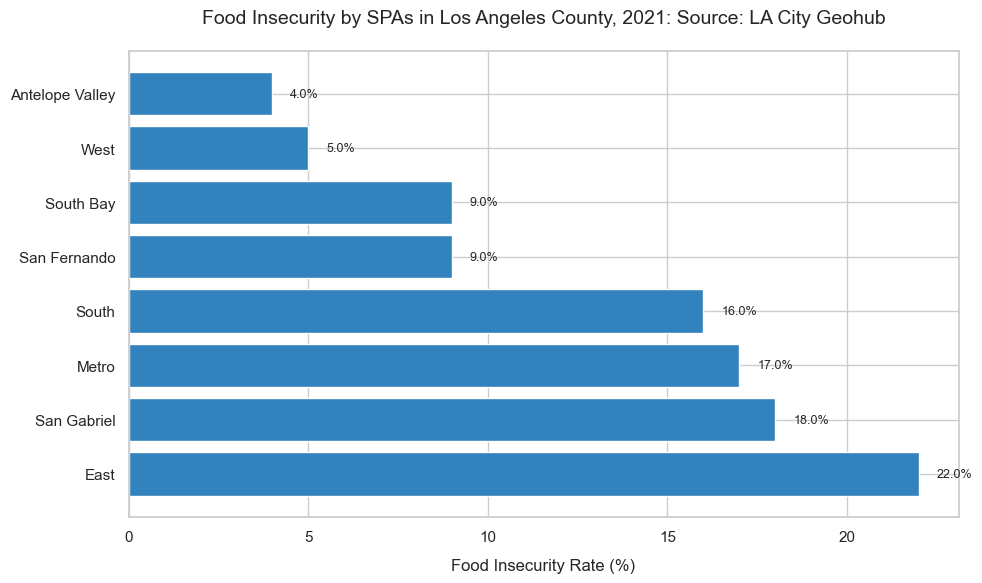

In [218]:
spa_names = fi_summary.index
rates = fi_summary['Food Insecurity Rate (%)']

fig5, ax = plt.subplots(figsize=(10, 6))
y = np.arange(len(spa_names))

bars = ax.barh(y, rates, color='#3182bd') 

# Labels and titles
ax.set_title('Food Insecurity by SPAs in Los Angeles County, 2021: Source: LA City Geohub', pad=20, fontsize=14)
ax.set_xlabel('Food Insecurity Rate (%)', labelpad=10)
ax.set_yticks(y)
ax.set_yticklabels(spa_names)

# Add data labels to bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', va='center', fontsize=9)

plt.tight_layout()

#### Explore city-level food insecurity rates

Text(0.5, 1.0, 'Food Insecurity by Cities in Los Angeles County, 2021: Source: LA City Geohub')

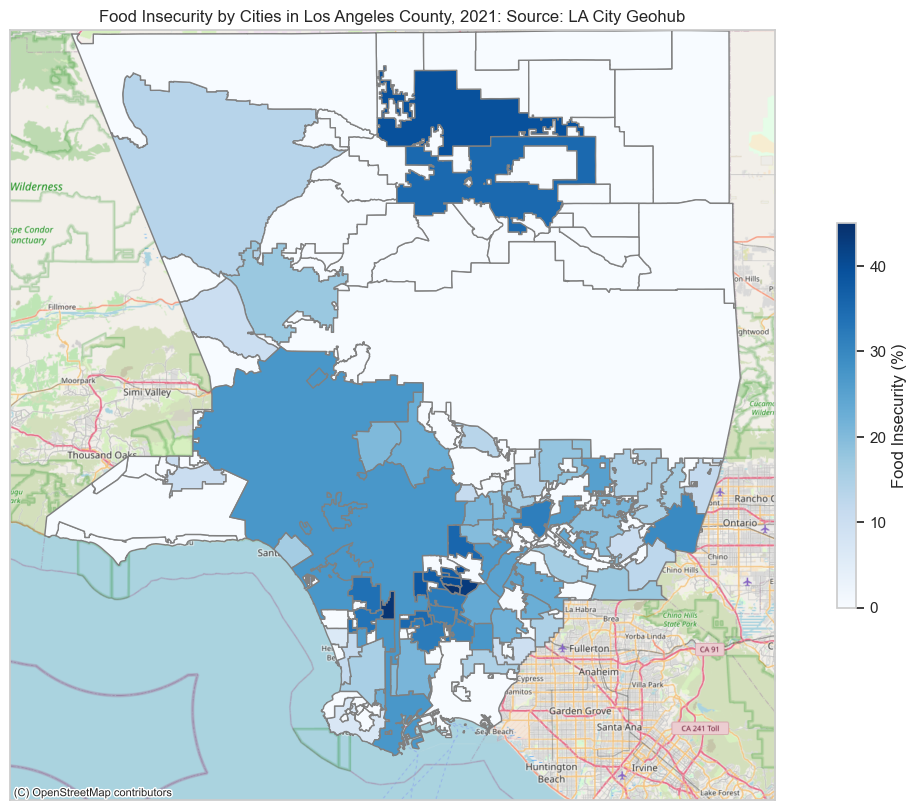

In [228]:
fig6, ax = plt.subplots(figsize=(16,10))

city_fi.to_crs('EPSG:3857').plot(
    column='POP_FI',
        ax=ax,
        markersize=20,  # Consistent size
        cmap='Blues',
        legend=True,
        edgecolor='gray',
        legend_kwds={'label': "Food Insecurity (%)",
        'shrink': 0.5,  # make the color bar shorter
        'aspect': 20} # controls width — higher = skinnier                         
                     )

# drop Catalina
ax.set_ylim([3.98e6, 4.14e6])

# add a basemap
ctx.add_basemap(ax=ax, zoom=10, source=ctx.providers.OpenStreetMap.Mapnik)

# drop the tick labels
ax.set_xticks([])
ax.set_yticks([])

# add a title
ax.set_title('Food Insecurity by Cities in Los Angeles County, 2021: Source: LA City Geohub')

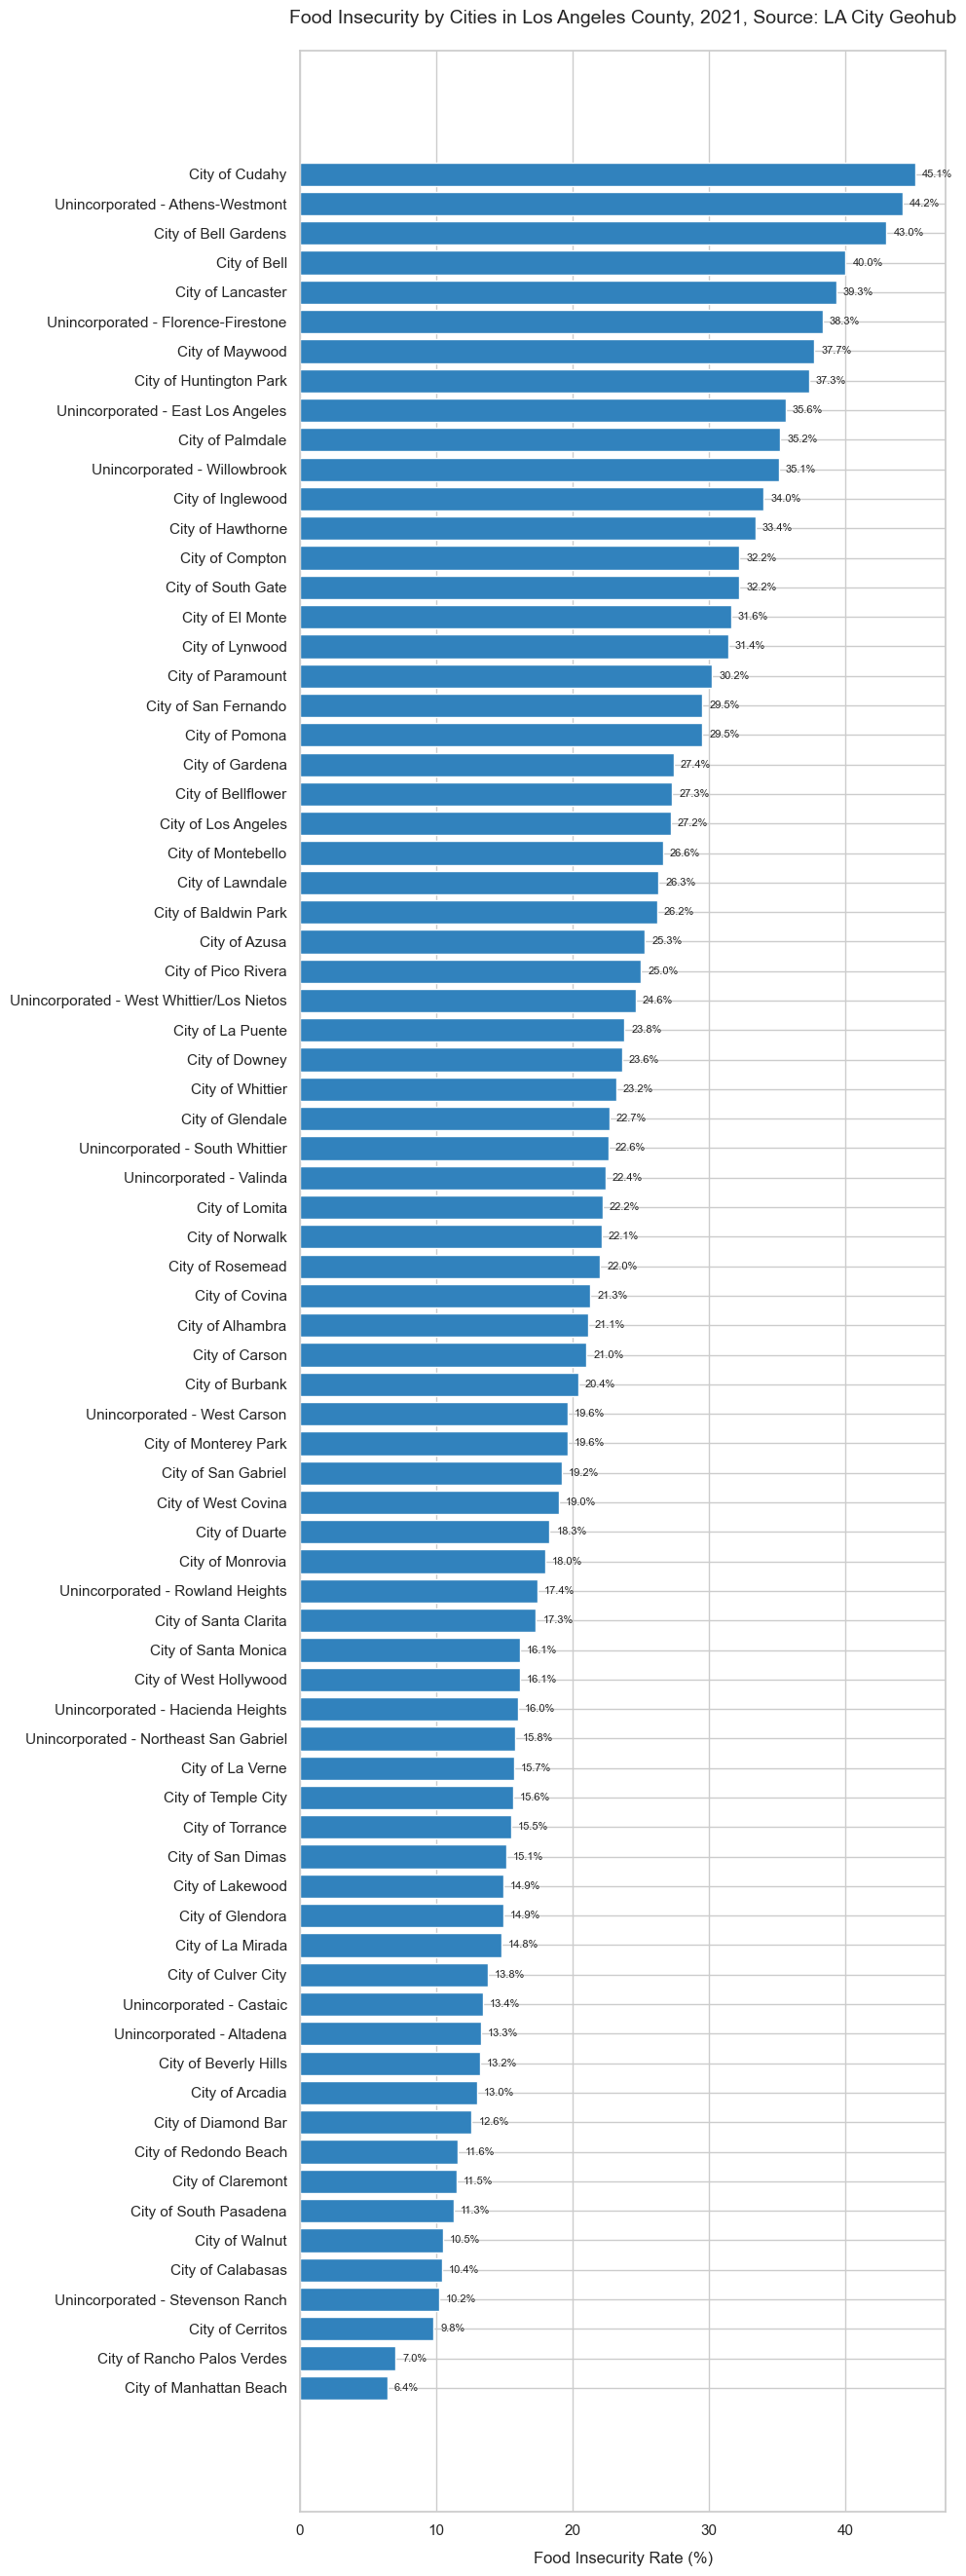

In [226]:
import numpy as np
import matplotlib.pyplot as plt

# Clean and filter: remove 0% and drop missing or blank city names
city_fi_clean = city_fi[
    (city_fi['POP_FI'] > 0) &
    (city_fi['Geo_Name'].notna()) &
    (city_fi['Geo_Name'].str.strip() != '')
]

# Sort cities by food insecurity rate
city_fi_sorted = city_fi_clean.sort_values('POP_FI', ascending=True)

# Extract city names and food insecurity rates
city_names = city_fi_sorted['Geo_Name'].str.strip()
rates = city_fi_sorted['POP_FI']

# Set up plot
fig6, ax = plt.subplots(figsize=(10, len(city_names) * 0.35))

y = np.arange(len(city_names))
bars = ax.barh(y, rates, color='#3182bd')

# Labels and titles
ax.set_title('Food Insecurity by Cities in Los Angeles County, 2021, Source: LA City Geohub', pad=20, fontsize=14)
ax.set_xlabel('Food Insecurity Rate (%)', labelpad=10)
ax.set_yticks(y)
ax.set_yticklabels(city_names)

# Add data labels
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', va='center', fontsize=8)

plt.tight_layout()